In [74]:
from graphMatching import *
from networkx import read_edgelist
from scipy.io import loadmat
from model_PyG import *
# from utils import *

In [75]:
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torch_geometric.transforms as T

from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from torch.optim import Adam
from torch_geometric.utils import negative_sampling
from torch_geometric.data import InMemoryDataset, Data
from torch.nn.functional import binary_cross_entropy_with_logits
from torch_geometric.transforms import (
	Compose,
	NormalizeFeatures,
	ToUndirected,
	AddSelfLoops,
	RemoveSelfLoops
)

In [76]:
import torch_geometric
print(torch_geometric.__version__)

np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

2.7.0


### Setup

In [77]:
data = "ACM_DBLP" # args.dataset
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")
train_features = {}
if (data == "ACM_DBLP"):
	train_set = ["ACM", "DBLP"]
	# input_dim = 17
	b = np.load('data/ACM-DBLP.npz')
	train_features["ACM"] = [torch.from_numpy(b["x1"]).float()]
	train_features["DBLP"] = [torch.from_numpy(b["x2"]).float()]
	test_pairs = b['test_pairs'].astype(np.int32)
	NUM_HIDDEN_LAYERS = 12
	HIDDEN_DIM = [1024,1024,1024,1024,1024,1024,1024,1024,1024,1024,1024,1024,1024]
	output_feature_size = 128
	lr = 5e-4 # 1e-4
	epoch = 100
elif (data == "Douban Online_Offline"):
	a1, f1, a2, f2, test_pairs = load_douban()
	f1 = f1.A
	f2 = f2.A
	train_set = ["Online", "Offline"]
	input_dim = 538
	test_pairs = torch.tensor(np.array(test_pairs, dtype=int)) - 1
	test_pairs = test_pairs.numpy()
	train_features["Online"] = [torch.from_numpy(f1).float()]
	train_features["Offline"] = [torch.from_numpy(f2).float()]
	NUM_HIDDEN_LAYERS = 6
	HIDDEN_DIM = [512,512,512,512,512,512,512]
	output_feature_size = 512
	lr = 0.0001
	epoch = 20

### Understand Data (PyG)

In [78]:
#
train_set 

['ACM', 'DBLP']

In [79]:
#
b.files

['edge_index1', 'edge_index2', 'x1', 'x2', 'pos_pairs', 'test_pairs']

In [80]:
#
edge_index1 = b["edge_index1"]
print(edge_index1.shape)
edge_index1

(2, 79122)


array([[   0,    0,    0, ..., 9870, 9870, 9871],
       [   1,    2,    3, ..., 1586, 2482, 4454]], dtype=int32)

In [81]:
#
edge_index2 = b["edge_index2"]
print(edge_index2.shape)
edge_index2

(2, 89616)


array([[   0,    0,    0, ..., 9915, 9915, 9915],
       [ 450, 4031, 4447, ..., 2565, 3529, 5843]], dtype=int32)

In [82]:
#
x1 = b["x1"]
print(x1.shape)
x1

(9872, 17)


array([[61, 42, 16, ..., 14,  1, 22],
       [54, 18, 12, ..., 11,  0, 16],
       [54, 61,  9, ..., 10,  0, 39],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  1,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  1]], dtype=uint8)

In [83]:
#
x2 = b["x2"]
print(x2.shape)
x2

(9916, 17)


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 4, 1],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0]], dtype=uint8)

In [84]:
#
test_pairs

array([[   0, 6829],
       [   2, 3102],
       [   3, 3584],
       ...,
       [9841, 3392],
       [9850,  306],
       [9868, 9011]], dtype=int32)

In [85]:
def info(data):
	print("Validate:\t {}".format(data.validate(raise_on_error=True)))
	print("Num. nodes:\t {}".format(data.num_nodes))
	print("Num. edges:\t {}".format(data.num_edges))
	print("Num. features:\t {}".format(data.num_node_features))
	print("Has isolated:\t {}".format(data.has_isolated_nodes()))
	print("Has loops:\t {}".format(data.has_self_loops()))
	print("Is directed:\t {}".format(data.is_directed()))
	print("Is undirected:\t {}".format(data.is_undirected()))
	print("{}".format(data.edge_index))
	print("{}".format(data.x))
	print("{}".format(data.edge_weight))


In [86]:
#
edge_index = torch.tensor([
	[0, 1],
	[1, 2]], dtype=torch.long)
x = torch.tensor([[-1, 4], [0, 1], [1, 2]], dtype=torch.float)
edge_weight = torch.tensor([0.5, 1.0], dtype=torch.float)

data = Data(x=x, edge_index=edge_index, edge_weight=edge_weight)

info(data)

Validate:	 True
Num. nodes:	 3
Num. edges:	 2
Num. features:	 2
Has isolated:	 False
Has loops:	 False
Is directed:	 True
Is undirected:	 False
tensor([[0, 1],
        [1, 2]])
tensor([[-1.,  4.],
        [ 0.,  1.],
        [ 1.,  2.]])
tensor([0.5000, 1.0000])


In [87]:
#
edge_index = torch.tensor([
	[0, 1],
	[1, 2]], dtype=torch.long)
x = torch.tensor([[-1, 4], [0, 1], [1, 2]], dtype=torch.float)
edge_weight = torch.tensor([0.5, 1.0], dtype=torch.float)

data = Data(x=x, edge_index=edge_index, edge_weight=edge_weight)

transform = Compose([
	T.NormalizeFeatures(),
	T.ToUndirected(),
	T.AddSelfLoops(fill_value=1.0),
	T.ToDevice(device),
])

data = transform(data)

info(data)

Validate:	 True
Num. nodes:	 3
Num. edges:	 7
Num. features:	 2
Has isolated:	 False
Has loops:	 True
Is directed:	 False
Is undirected:	 True
tensor([[0, 1, 1, 2, 0, 1, 2],
        [1, 0, 2, 1, 0, 1, 2]], device='cuda:0')
tensor([[0.0000, 1.0000],
        [0.3333, 0.6667],
        [0.4000, 0.6000]], device='cuda:0')
tensor([0.5000, 0.5000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       device='cuda:0')


### Create Data (PyG)

In [88]:
transform = Compose([
	T.NormalizeFeatures(),
	# T.ToUndirected(),
	T.AddSelfLoops(fill_value=1.0),
	T.ToDevice(device),
])

In [89]:
edge_index1 = torch.tensor(edge_index1, dtype=torch.long)
x1 = torch.tensor(x1, dtype=torch.float)

data1 = Data(x=x1, edge_index=edge_index1)
data1 = transform(data1)
info(data1)

Validate:	 True
Num. nodes:	 9872
Num. edges:	 88994
Num. features:	 17
Has isolated:	 False
Has loops:	 True
Is directed:	 False
Is undirected:	 True
tensor([[   0,    0,    0,  ..., 9869, 9870, 9871],
        [   1,    2,    3,  ..., 9869, 9870, 9871]], device='cuda:0')
tensor([[0.2210, 0.1522, 0.0580,  ..., 0.0507, 0.0036, 0.0797],
        [0.2741, 0.0914, 0.0609,  ..., 0.0558, 0.0000, 0.0812],
        [0.1725, 0.1949, 0.0288,  ..., 0.0319, 0.0000, 0.1246],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 1.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 1.0000]],
       device='cuda:0')
None


In [90]:
#
edge_index2 = torch.tensor(edge_index2, dtype=torch.long)
x2 = torch.tensor(x2, dtype=torch.float)

data2 = Data(x=x2, edge_index=edge_index2)
data2 = transform(data2)
info(data2)

Validate:	 True
Num. nodes:	 9916
Num. edges:	 99532
Num. features:	 17
Has isolated:	 False
Has loops:	 True
Is directed:	 False
Is undirected:	 True
tensor([[   0,    0,    0,  ..., 9913, 9914, 9915],
        [ 450, 4031, 4447,  ..., 9913, 9914, 9915]], device='cuda:0')
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.4000, 0.1000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 1.0000, 0.0000, 0.0000]],
       device='cuda:0')
None


In [91]:
print("Loading training datasets")
train_loader = {}
train_loader[train_set[0]] = data1
train_loader[train_set[1]] = data2
train_loader

Loading training datasets


{'ACM': Data(x=[9872, 17], edge_index=[2, 88994]),
 'DBLP': Data(x=[9916, 17], edge_index=[2, 99532])}

### Train

In [92]:
def compute_num_neg_samples(edge_index, num_nodes, ratio):
	E = edge_index.size(1)
	max_neg = num_nodes * num_nodes - E
	return min(int(ratio * E), max_neg)

def neg_ratio_schedule(epoch, max_epoch):
	start = 5.0
	end = 1.0
	return start - (start - end) * (epoch / max_epoch)

class EarlyStopping:
	def __init__(self, patience=5, delta=0, warmup=5, verbose=False):
		self.patience = patience
		self.delta = delta
		self.warmup = warmup
		self.verbose = verbose
		self.best_loss = None
		self.no_improvement_count = 0
		self.stop_training = False
	
	def check_early_stop(self, loss, epoch):
		if epoch >= self.warmup:
			if self.best_loss is None or loss < self.best_loss - self.delta:
				self.best_loss = loss
				self.no_improvement_count = 0
			else:
				self.no_improvement_count += 1
				if self.no_improvement_count >= self.patience:
					self.stop_training = True
					if self.verbose:
						print("Stopping early as no improvement has been observed.")

In [93]:
def fit_TGAE_subgraph(data, no_samples, model, epochs, train_loader, train_features, device, lr, test_pairs):
	best_hitAtOne = 0
	best_hitAtFive = 0
	best_hitAtTen = 0
	best_hitAtFifty = 0
	list_loss = []

	optimizer = Adam(model.parameters(), lr=lr,weight_decay=5e-4)
	
	# Initialize early stopping
	patience = 10
	delta = 1e-4
	warmup = 5
	early_stopping = EarlyStopping(patience=patience, delta=delta, warmup=warmup, verbose=True)

	loop_obj = tqdm(range(1, epochs + 1))
	for epoch in loop_obj:
		loop_obj.set_description(f"Epoch: {epoch}")
		
		# Train
		model.train()
		loss = 0.0
		
		for dataset, data_obj in train_loader.items():
			x = data_obj.x
			edge_index = data_obj.edge_index
			
			# Encoder
			z = model(x, edge_index)
			# z = F.normalize(z, dim=1)

			# Positive edges
			pos_edge_index = edge_index
			
			# Negative edges
			# option 1
			neg_edge_index = negative_sampling(
				edge_index=edge_index,
				num_nodes=z.size(0),
				num_neg_samples=pos_edge_index.size(1), # Change 2 to other value if needed
				method="sparse"
			)
			# Negative edges (dynamic)
			# option 2
			""" ratio = neg_ratio_schedule(epoch, epochs)
			num_neg = compute_num_neg_samples(
				edge_index=edge_index,
				num_nodes=z.size(0),
				ratio=ratio
			)
			neg_edge_index = negative_sampling(
				edge_index=edge_index,
				num_nodes=z.size(0),
				num_neg_samples=num_neg,
				method="sparse"
			) """
			
			# Decoder
			pos_logits = (z[pos_edge_index[0]] * z[pos_edge_index[1]]).sum(dim=1)
			neg_logits = (z[neg_edge_index[0]] * z[neg_edge_index[1]]).sum(dim=1)

			pos_labels = torch.ones_like(pos_logits)
			neg_labels = torch.zeros_like(neg_logits)

			# Loss
			loss_pos = binary_cross_entropy_with_logits(pos_logits, pos_labels)
			loss_neg = binary_cross_entropy_with_logits(neg_logits, neg_labels)

			loss += loss_pos + loss_neg
			
		optimizer.zero_grad()
		loss = loss / no_samples
		loss.backward()
		optimizer.step()

		loop_obj.set_postfix_str(f"Loss: {loss.item():.4f}")
		list_loss.append(loss.item())

		# Evaluation
		model.eval()
		with torch.no_grad():
			keys = list(train_loader.keys())
			data1 = train_loader[keys[0]]
			data2 = train_loader[keys[1]]

			z1 = model(data1.x, data1.edge_index).detach()
			z2 = model(data2.x, data2.edge_index).detach()

			# z1 = F.normalize(z1, dim=1)
			# z2 = F.normalize(z2, dim=1)
			
			D = torch.cdist(z1, z2, 2)
			
			if data == "ACM_DBLP":
				test_idx = test_pairs[:, 0].astype(int)
				labels = test_pairs[:, 1].astype(int)
			else:
				test_idx = test_pairs[0, :].astype(int)
				labels = test_pairs[1, :].astype(int)
				
			hitAtOne = 0
			hitAtFive = 0
			hitAtTen = 0
			hitAtFifty = 0
			hitAtHundred = 0
			for i in range(len(test_idx)):
				dist_list = D[test_idx[i]]
				sorted_neighbors = torch.argsort(dist_list).cpu()
				label = labels[i]
				for j in range(100):
					if (sorted_neighbors[j].item() == label):
						if (j == 0):
							hitAtOne += 1
							hitAtFive += 1
							hitAtTen += 1
							hitAtFifty += 1
							hitAtHundred += 1
							break
						elif (j <= 4):
							hitAtFive += 1
							hitAtTen += 1
							hitAtFifty += 1
							hitAtHundred += 1
							break
						elif (j <= 9):
							hitAtTen += 1
							hitAtFifty += 1
							hitAtHundred += 1
							break
						elif (j <= 49):
							hitAtFifty += 1
							hitAtHundred += 1
							break
						elif (j <= 100):
							hitAtHundred += 1
							break
			cur_hitAtOne = hitAtOne / len(test_idx)
			cur_hitAtFive = hitAtFive / len(test_idx)
			cur_hitAtTen = hitAtTen / len(test_idx)
			cur_hitAtFifty = hitAtFifty / len(test_idx)

			if(cur_hitAtOne > best_hitAtOne): best_hitAtOne = cur_hitAtOne
			if (cur_hitAtFive > best_hitAtFive): best_hitAtFive = cur_hitAtFive
			if (cur_hitAtTen > best_hitAtTen): best_hitAtTen = cur_hitAtTen
			if (cur_hitAtFifty > best_hitAtFifty): best_hitAtFifty = cur_hitAtFifty

		# Check early stopping condition
		early_stopping.check_early_stop(loss.item(), epoch)
		if early_stopping.stop_training:
			print(f"Early stopping at epoch {epoch}")
			break

	print("The best results achieved:")
	print("Hit@1: ", end="")
	print(best_hitAtOne)
	print("Hit@5: ", end="")
	print(best_hitAtFive)
	print("Hit@10: ", end="")
	print(best_hitAtTen)
	print("Hit@50: ", end="")
	print(best_hitAtFifty)

	torch.cuda.empty_cache()

	return [z1, z2], list_loss

In [94]:
data = "ACM_DBLP"
no_samples = len(train_set) # * (1 + 1)  # num datasets * num of samples by dataset 
input_dim = train_loader[train_set[0]].num_node_features

model = TGAE(NUM_HIDDEN_LAYERS,
			input_dim,
			HIDDEN_DIM,
			output_feature_size).to(device)

print("Generating training features")
print("Fitting model")
print(lr, epoch, output_feature_size, no_samples)

list_z, list_loss = fit_TGAE_subgraph(data, no_samples, model, epoch, train_loader, train_features, device, lr,test_pairs)

Generating training features
Fitting model
0.0005 100 128 2


Epoch: 22:  21%|██        | 21/100 [00:36<02:18,  1.75s/it, Loss: 24.9713] 

Stopping early as no improvement has been observed.
Early stopping at epoch 22
The best results achieved:
Hit@1: 0.6705533596837945
Hit@5: 0.8482213438735178
Hit@10: 0.9057312252964427
Hit@50: 0.9614624505928854


In [99]:
list_z[0].size(0)

9872

### Plot

In [116]:
list_loss

[1.6792817115783691,
 184.34954833984375,
 40.66480255126953,
 46.869632720947266,
 185.83053588867188,
 44.72694396972656,
 198.45596313476562,
 63.79792404174805,
 47.62068176269531,
 48.771034240722656,
 20.957048416137695,
 13.85026741027832,
 67.09544372558594,
 65.44537353515625,
 15.052218437194824,
 21.22980499267578,
 53.42238235473633,
 138.79354858398438,
 48.564796447753906,
 53.821632385253906,
 46.67732238769531,
 24.97127914428711]

In [113]:
# Concatenate embeddings
z_cat = torch.cat(list_z, dim=0).cpu().numpy()
print(z_cat.shape)
z_cat

(19788, 128)


array([[-0.25802818,  0.22217047,  0.22221716, ..., -0.17180671,
        -0.41715807, -0.06087919],
       [-0.2613762 ,  0.22393031,  0.22505789, ..., -0.17399092,
        -0.4201775 , -0.05969854],
       [-0.25717643,  0.21872236,  0.22079234, ..., -0.17197242,
        -0.4120339 , -0.06371205],
       ...,
       [-0.23211977,  0.25257865,  0.21040125, ..., -0.18656307,
        -0.42665824, -0.07645828],
       [-0.23700278,  0.21102561,  0.2677588 , ..., -0.1883946 ,
        -0.38471046, -0.04723369],
       [-0.25301036,  0.24037905,  0.24152519, ..., -0.19852084,
        -0.42607346, -0.04763341]], dtype=float32)

In [114]:
labels = np.array([0] * list_z[0].size(0) + [1] * list_z[1].size(0))
print(labels.shape)
labels

(19788,)


array([0, 0, 0, ..., 1, 1, 1])

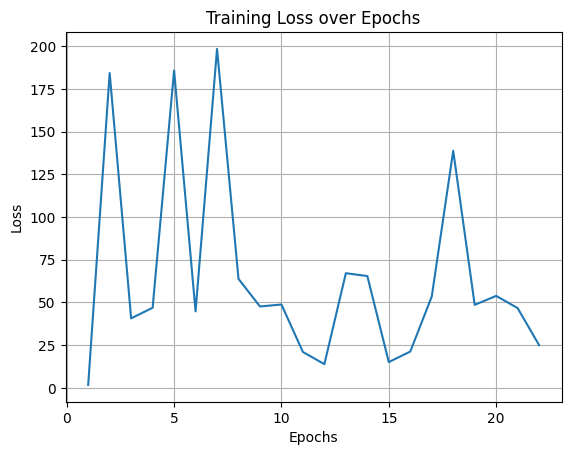

In [117]:
# Loss

plt.figure()
plt.plot(range(1, len(list_loss) + 1), list_loss) #, marker=".")
plt.title("Training Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.show()

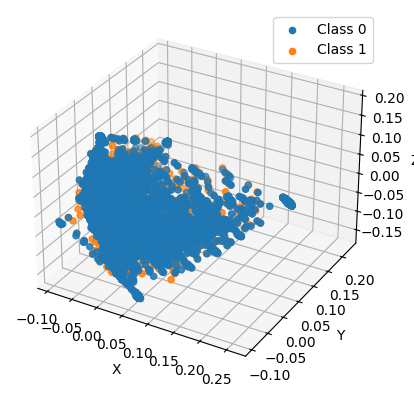

In [118]:
# Node embeddings

if z_cat.shape[1] > 3:
	pca = PCA(n_components=3)
	z_cat = pca.fit_transform(z_cat)


fig = plt.figure()
ax = fig.add_subplot(projection="3d")

for c in np.unique(labels):
	ax.scatter(z_cat[:, 0][labels == c], z_cat[:, 1][labels == c], z_cat[:, 2][labels == c], label=f"Class {c}")

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.legend()

plt.show()